<a href="https://colab.research.google.com/github/JungWoo-Chae/Generative_Models/blob/main/PGGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **mini PGGAN with Wasserstein GP Loss & CIFAR10 horse image**


In this code, The whole Model is build at once and then train progressively, rather than the model is growing up progressively like in the paper. This code  might uses memory inefficiently but nonetheless it is more perspective to under stand the algorithm which is called progressively growing. 

## **Imports**

In [26]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.autograd import Variable
from torch import autograd
from torch.nn.init import kaiming_normal, calculate_gain

In [27]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## **Model**

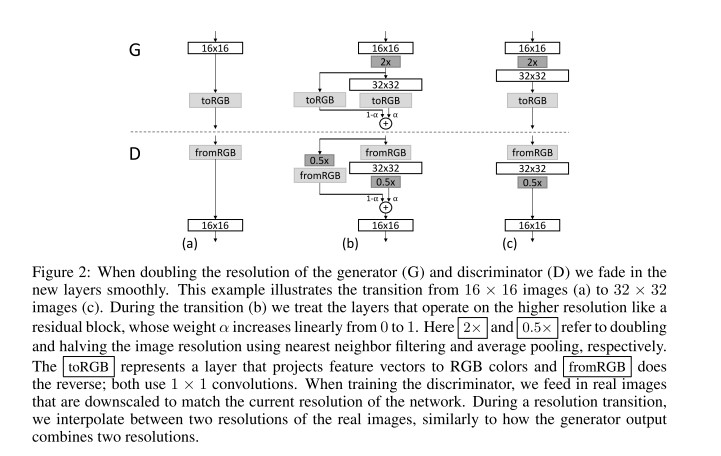

Model will be grow up while t is increased.

In [28]:
class Generator(nn.Module):
    def __init__(self, channels, nf, nl):
        super().__init__()
        self.nl = nl
        self.first_block = nn.Sequential(
            EqualizedDeconv2d(in_channels=100, out_channels=nf * 8, kernel_size=4, stride=1, padding=0),
            nn.LeakyReLU(0.2, inplace=True),
            PNLayer()
            )
        self.pool = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv = nn.ModuleList([nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            EqualizedConv2d(in_channels=nf * (2 **(nl-i)), out_channels=nf * (2 **(nl-i-1)), kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            PNLayer()            
            ) for i in range(nl)])

        self.toRGB = nn.ModuleList([nn.Sequential(
            EqualizedConv2d(in_channels=nf * (2 **(nl-i)), out_channels=channels, kernel_size=3, stride=1, padding=1),
            nn.Tanh()) for i in range(nl+1)])

    def forward(self, x, t=3, alpha=1):
        x = self.first_block(x)
        for i in range(t-1):
            x = self.conv[i](x)
        if t != 0 :
            x2 = self.conv[t-1](x)
            x2 = self.toRGB[t](x2)
            x = self.pool(x)
            x = self.toRGB[t-1](x)
            x = x2.mul(alpha) + x.mul(1-alpha)
        else:
            x = self.toRGB[t](x)
        
        return x


In [37]:
class Discriminator(nn.Module):
    def __init__(self, channels, nf, nl):
        super().__init__()
        self.nl = nl
        self.fromRGB = nn.ModuleList([nn.Sequential(
            EqualizedConv2d(in_channels=channels, out_channels=nf * (2 **(nl-i)), kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.InstanceNorm2d(nf* (2 **(nl-i)), affine=True)) for i in range(nl+1)])

        self.conv = nn.ModuleList([nn.Sequential(
            EqualizedConv2d(in_channels=nf * (2 **(i)), out_channels=nf * (2 **(i+1)), kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.InstanceNorm2d(nf * (2 **(i+1)), affine=True)
            ) for i in range(nl)])

        self.last_block = nn.Sequential(
            EqualizedConv2d(in_channels=nf * 8 + 1, out_channels=1, kernel_size=4, stride=1, padding=0))
        
        self.MiniBatchStddev = MiniBatchStddev()
    

    def forward(self, x, t= 3 , alpha=1):
        if t != 0 :
            x2 = self.fromRGB[t](x)
            x2 = self.conv[self.nl - t](x2)
            x = F.max_pool2d(x , 2, 2)
            x = self.fromRGB[t-1](x)
            x = x2.mul(alpha) + x.mul(1-alpha)
        else:
            x = self.fromRGB[t](x)

        for i in range(self.nl-t+1, self.nl):
            x = self.conv[i](x)
        x = self.MiniBatchStddev(x)
        
        return self.last_block(x)

### INCREASING VARIATION USING MINIBATCH STANDARD DEVIATION


In [38]:
class MiniBatchStddev(nn.Module):
    def __init__(self):
        super(MiniBatchStddev, self).__init__()

    def forward(self, x):
        x2 = x.std(dim=0)
        x2= x2.mean(dim=0,keepdim=True)
        x2 = x2.view(1,*x2.size())
        x2 = x2.repeat(x.size()[0], 1, 1, 1)
        x = torch.cat((x,x2),1)
        return x

### EQUALIZED LEARNING RATE
EqualizedLayer which makes Equalized Learning speed at every other layers.

In [39]:
class EqualizedConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride= 1, padding=1, gain=2):
        super(EqualizedConv2d, self).__init__()

        self.conv =  nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,
                                  stride= stride, padding=padding)
        # nn.init.normal_(self.conv.weight)
        kaiming_normal(self.conv.weight, a=calculate_gain('conv2d'))
        self.norm_const  = np.sqrt(gain/self.conv.weight[0].numel())

    def forward(self, x):
        return  self.conv(x.mul(self.norm_const))

In [40]:
class EqualizedDeconv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride= 1, padding=1, gain=2):
        super(EqualizedDeconv2d, self).__init__()

        self.conv =  nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size,
                                  stride= stride, padding=padding)
        # nn.init.normal_(self.conv.weight)
        kaiming_normal(self.conv.weight, a=calculate_gain('conv2d'))
        self.norm_const  = np.sqrt(gain/self.conv.weight[0].numel())

    def forward(self, x):
        return self.conv(x.mul(self.norm_const))

### PIXELWISE FEATURE VECTOR NORMALIZATION IN GENERATOR

In [41]:
class PNLayer(nn.Module):
    def __init__(self):
        super(PNLayer, self).__init__()
        
    def forward(self, x):
        return x * torch.rsqrt(torch.mean(x ** 2, dim=1, keepdim=True) + 1e-8)

In [42]:
z_dim = 100
channels = 3
nf = 64
nl = 3  # log (64/4)

In [43]:
D = Discriminator(channels ,nf, nl)
D = D.to(device)
G = Generator(channels, nf, nl)
G = G.to(device)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  


## **Dataset**

In [46]:
transform_lst = [torchvision.transforms.Compose([
    torchvision.transforms.Resize((2**(nl+2-i),2**(nl+2-i)), interpolation=2),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]) for i in range(nl+1)
    ]

In [47]:
dataset_lst = []
for i in range(nl+1):
    dataset = torchvision.datasets.CIFAR10('./data', transform=transform_lst[i],download=True)
    dataset.targets = torch.tensor(dataset.targets)
    idx = dataset.targets==7
    dataset.targets= dataset.targets[idx]
    dataset.data = dataset.data[idx.numpy().astype(np.bool)]
    dataset_lst.append(dataset)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Training

In [53]:
losses = []
checkpoints = []

In [54]:
def compute_gradient_penalty(D,t,alpha, real_samples, fake_samples):
    alpha = torch.randn(real_samples.size(0), 1, 1, 1, device=device)
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates, t,alpha)
    fake = torch.ones(d_interpolates.size()).to(device)
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [55]:
losses = []
checkpoints = []

def train(epochs, batch_size, sample_interval):
    
    D.train()
    G.train()
    
    d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
    g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

    #max grow
    mg = 3
    #number of data
    nd = dataset_lst[0].__len__()
    #the number of batches per epoch
    nbp = nd//batch_size
    #number of epochs to grow 
    neg = epochs//(mg+1)
    #number of batches to grow
    nbg = nbp * neg +1

    iteration = 0
    for epoch in range(epochs):
        t = min(mg, epoch//neg)
        train_loader = torch.utils.data.DataLoader(dataset_lst[mg-t], batch_size=batch_size,
                                        shuffle=True, num_workers=4,pin_memory=True)

        for imgs, _ in train_loader:    
            imgs = imgs.to(device)
            alpha = min(1, (iteration%nbg)/nbg)
            if len(imgs) != batch_size:
                break
            
            for p in D.parameters():
                    p.requires_grad = True
            
            D.zero_grad()
            
            z = torch.randn(batch_size, z_dim,1,1, device=device)
            gen_imgs = G(z, t=t, alpha=alpha)


            gradient_penalty = compute_gradient_penalty(D,t,alpha, imgs.data, gen_imgs.data)

            d_loss = -1 * torch.mean(D(imgs, t=t, alpha=alpha)) + torch.mean(D(gen_imgs, t=t, alpha=alpha)) + 10 * gradient_penalty

            
            d_loss.backward()
            d_optimizer.step()


            if iteration%5==0:
                for p in D.parameters():
                    p.requires_grad = False

                G.zero_grad()
                
                z = torch.randn(batch_size, z_dim,1,1, device=device)
                gen_imgs = G(z, t=t, alpha=alpha)
                g_loss = - torch.mean(D(gen_imgs, t=t, alpha=alpha))
                 
                g_loss.backward()
                g_optimizer.step()

            iteration +=1

        print("%d/%d [D loss: %f] [G loss: %f]" % (epoch + 1, epochs, d_loss.item(), g_loss.item()))
        if (epoch+1) % sample_interval == 0:
            losses.append((d_loss.cpu().detach().numpy(), g_loss.cpu().detach().numpy()))
            checkpoints.append(epoch + 1)
            
            sample_images(G, t=t, alpha=alpha)
            

In [56]:
def sample_images(generator, t=3, alpha=1, image_grid_rows=2, image_grid_columns=5):

    z = torch.randn(image_grid_rows * image_grid_columns, z_dim, 1, 1, device=device)

    labels = np.arange(0, 10)
    labels = torch.tensor(labels).to(device)

    gen_imgs = generator(z,t,alpha).cpu().detach().numpy()

    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(10, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            tmp = gen_imgs[cnt]
            axs[i,j].imshow(tmp.transpose(1, 2, 0))
            axs[i, j].axis('off')
            cnt += 1

1/800 [D loss: 3.910125] [G loss: -0.037931]
2/800 [D loss: 3.135569] [G loss: -0.056410]
3/800 [D loss: 2.634126] [G loss: -0.060602]
4/800 [D loss: 1.907651] [G loss: -0.051355]
5/800 [D loss: 1.691891] [G loss: -0.044131]
6/800 [D loss: 1.506545] [G loss: -0.015089]
7/800 [D loss: 1.313585] [G loss: 0.019888]
8/800 [D loss: 1.201212] [G loss: 0.049167]
9/800 [D loss: 1.073060] [G loss: 0.045397]
10/800 [D loss: 1.042624] [G loss: 0.095426]
11/800 [D loss: 0.805773] [G loss: -0.048710]
12/800 [D loss: 0.710742] [G loss: 0.005804]
13/800 [D loss: 0.737968] [G loss: -0.010655]
14/800 [D loss: 0.874940] [G loss: -0.041531]
15/800 [D loss: 0.650948] [G loss: 0.023787]
16/800 [D loss: 0.584984] [G loss: 0.158035]
17/800 [D loss: 0.446572] [G loss: 0.250858]
18/800 [D loss: 0.821471] [G loss: 0.107194]
19/800 [D loss: 0.762913] [G loss: -0.172680]
20/800 [D loss: 0.768710] [G loss: -0.191429]
21/800 [D loss: 0.670163] [G loss: -0.059356]
22/800 [D loss: 0.556989] [G loss: 0.044988]
23/800 

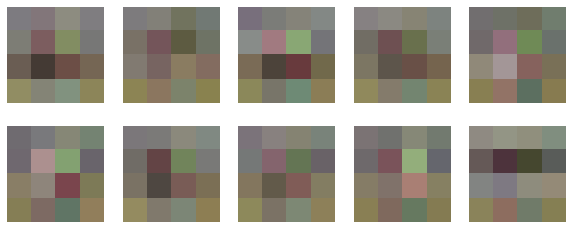

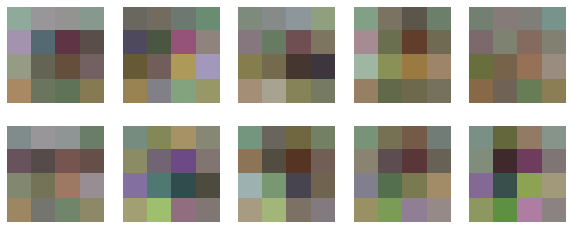

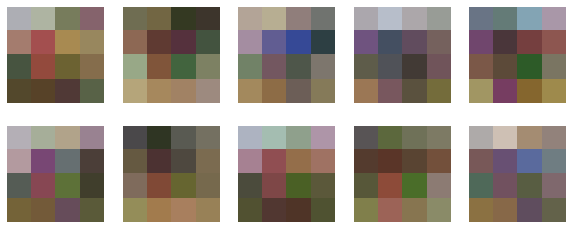

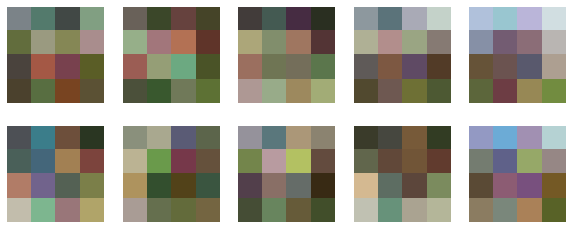

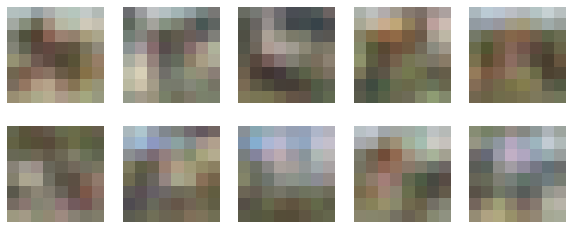

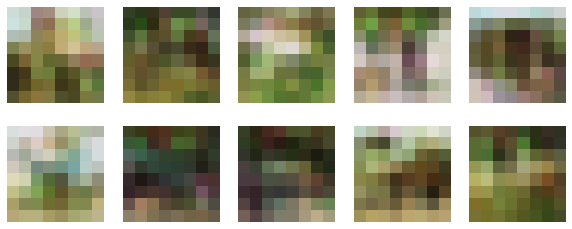

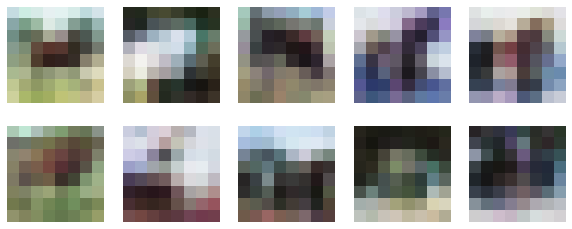

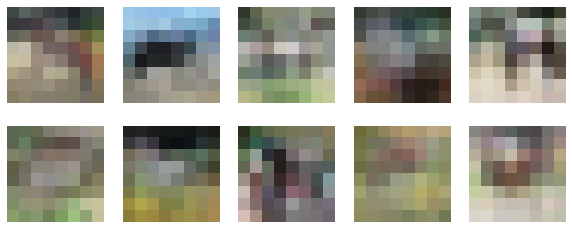

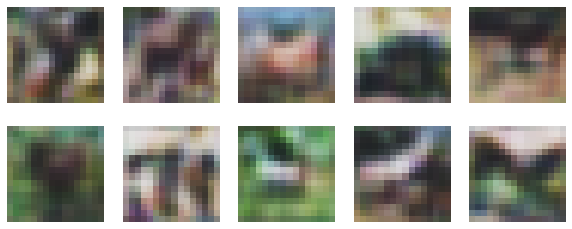

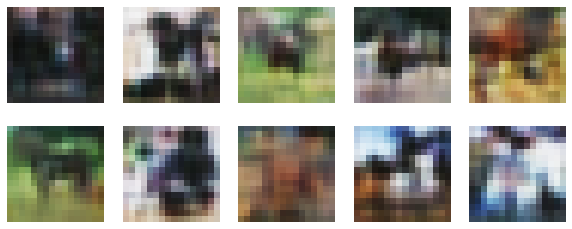

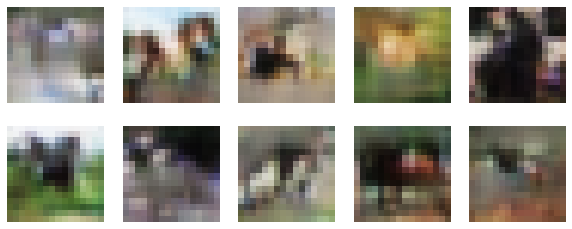

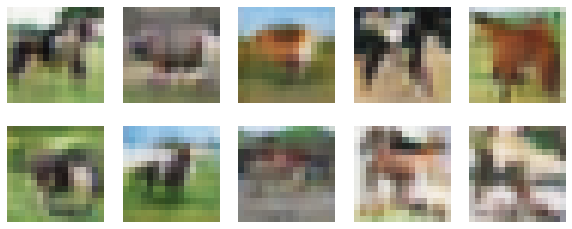

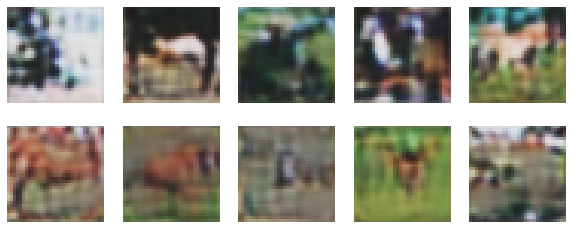

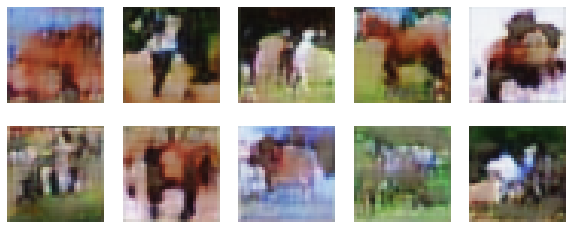

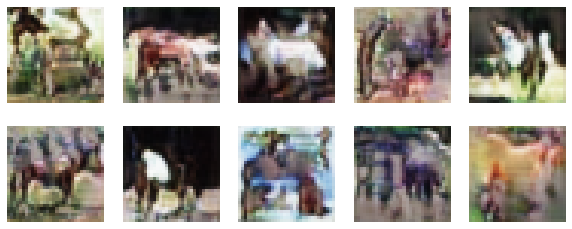

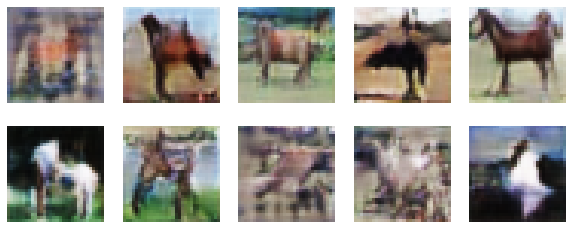

In [57]:
epochs = 800
batch_size = 256
sample_interval = 50

train(epochs, batch_size, sample_interval)

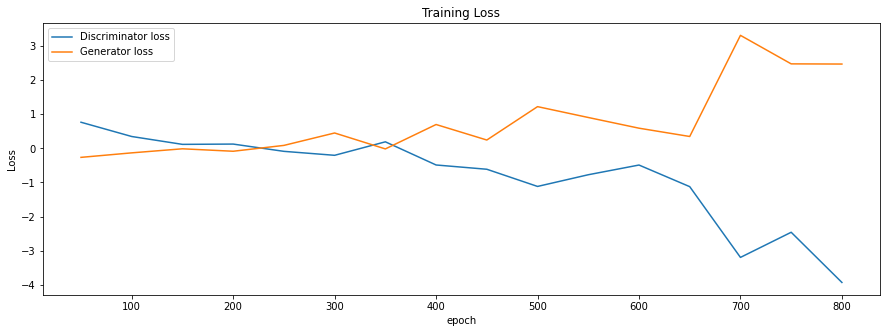

In [58]:
losses_ = np.array(losses)

plt.figure(figsize=(15, 5))
plt.plot(checkpoints, losses_.T[0], label="Discriminator loss")
plt.plot(checkpoints, losses_.T[1], label="Generator loss")

plt.title("Training Loss")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()